1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [115]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline 

import scipy as sp
from scipy import stats

import seaborn as sns

import pandas as pd

import warnings
warnings.filterwarnings('ignore')

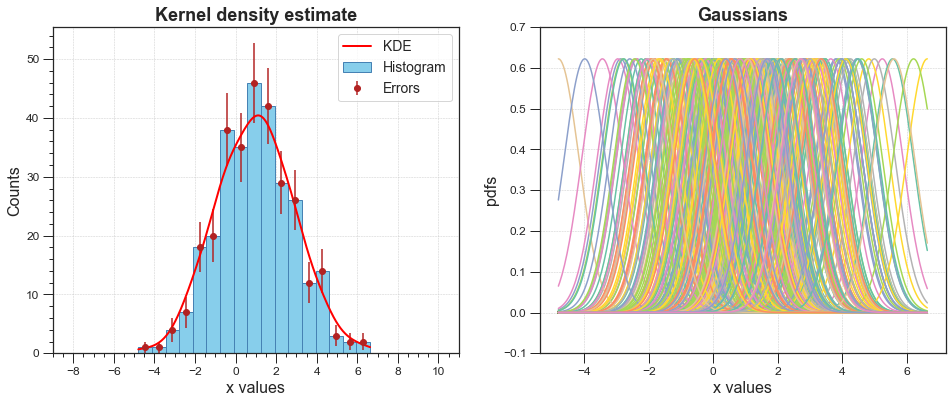

In [116]:
N = 300  
mean = 1
stdev = 2
x = np.array(np.random.normal(mean, stdev , N)) #normally distributed data

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
#ax1
nbins = int(np.sqrt(N)) #Poisson
histX = ax1.hist(x, bins=nbins,color = "skyblue", ec = "steelblue",  label='Histogram')
points = 0.5*(histX[1][1:] + histX[1][:-1])
ax1.errorbar(points, histX[0], yerr=histX[0]**(0.5), fmt='o', color='firebrick', label='Errors') 

ax1.xaxis.set_major_locator(ticker.MultipleLocator(2))
ax1.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(2))
ax1.set_xlabel("x values", fontsize=16)
ax1.set_ylabel("Counts", fontsize=16)
ax1.grid(linestyle="--", linewidth=0.5)
ax1.set_title("Kernel density estimate", fontsize=18, fontweight='bold')
ax1.tick_params(which= 'major', width=1.0, length=10, labelsize=12)
ax1.set_xlim(-5*stdev+mean, 5*stdev+mean)
ax1.legend(loc='best', fontsize=14)

#ax2
sigma = 1.06*x.std()*x.size**(-1/5)
xg = np.linspace(x.min(), x.max(), N)
gaussians = np.zeros((N,N))

for i in range(N):    
    gaussians[i] = stats.norm.pdf(xg, x[i], sigma)
    ax2.plot(xg, gaussians[i])
    
ax2.set_title("Gaussians", fontsize=18, fontweight='bold')
ax2.set_xlabel("x values", fontsize=16)
ax2.set_ylabel("pdfs", fontsize=16)
ax2.grid(linestyle="--", linewidth=0.5)
ax2.tick_params( width=1.0, length=10, labelsize=12)
ax2.set_ylim(-0.1,0.7)

#KDE
sumg = np.sum(gaussians, axis=0)
area = sp.integrate.trapz(y = sumg, x = xg)
normal = np.sum(np.diff(histX[1])*histX[0])/area
ax1.plot(xg, sumg*normal, '-r', linewidth=2, label='KDE')
ax1.legend(loc='best', fontsize=14)


2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

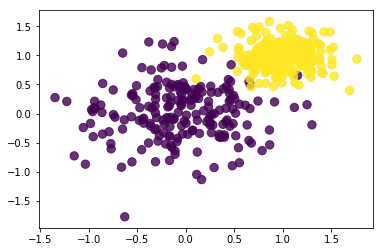

In [117]:
#! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

In [135]:
#Function to create n categories of 2D gaussian datasets
#Synthax:  n_cat2Dgauss(n, N)
#             N = number of data in each cathegory (n dim vector)
#             n = number of categories

mrange = [-10., 10.] #range of values for mean
srange = [-5., 5.]   #range of values for sigma

def n_cat2Dgauss(n, N): 
    means = [] #Array of means of the categories
    covs = []  #Array of covariance matrices of categories
    for i in range(n):
       #Mean of 2D distribution
        mean = np.random.uniform(mrange[0], mrange[1], size = 2) #1D array of length 2
        means.append(mean)
        #Covariance matrix of 2D distribution
        cov = np.random.uniform(srange[0], srange[1], size = (2,2)) #2D array of shape (2,2)
        cov = np.dot(cov, cov.T) #must positive semi-definite and symmetric
        covs.append(cov)
        dat = np.random.multivariate_normal(mean, cov, N[i])
        #Plot datasets
        plt.figure(1,figsize=(10,8))
        plt.grid(linestyle="-.", linewidth=0.6)
        plt.scatter(dat[:,0], dat[:,1], label = "Category "+str(i+1), marker='o',alpha=0.4)
        plt.legend(loc = 'best')
    return means, covs 


Mean of category 1 = 
 [-3.24060536 -8.52553326] 

Covariance matrix of category 1 = 
 [[ 3.57390525 -0.00900687]
 [-0.00900687  1.77087047]] 

Mean of category 2 = 
 [ 2.08953696 -2.00605675] 

Covariance matrix of category 2 = 
 [[13.9003343   6.70869097]
 [ 6.70869097 15.56473248]] 



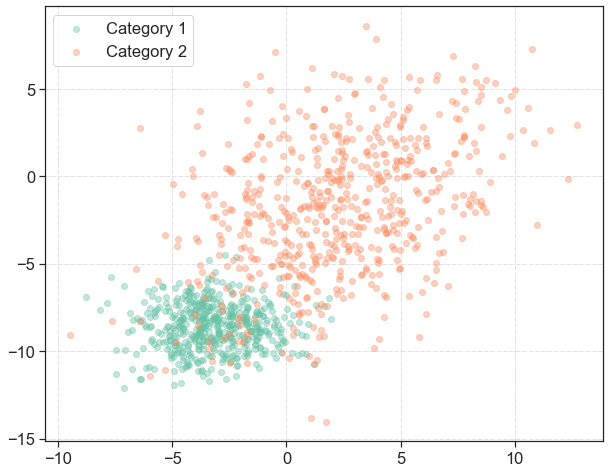

In [166]:
#With n=2
n = 2
N = np.array([500, 600]) #1st category has 200 points, 2nd has 400
M,C = n_cat2Dgauss(n,N)

for i in range(n):
    print("Mean of category", i+1, "=", '\n', M[i],'\n')
    print("Covariance matrix of category", i+1, "=", '\n', C[i], '\n')

Mean of category 1 = 
 [-1.73817379 -2.14546752] 

Covariance matrix of category 1 = 
 [[25.72892584 12.38820791]
 [12.38820791 10.24298613]] 

Mean of category 2 = 
 [ 7.40865075 -7.5036701 ] 

Covariance matrix of category 2 = 
 [[16.01090802  4.85747526]
 [ 4.85747526  7.63595592]] 

Mean of category 3 = 
 [8.23806499 8.13983797] 

Covariance matrix of category 3 = 
 [[16.6379407   3.18335478]
 [ 3.18335478 15.11369466]] 

Mean of category 4 = 
 [ 6.73418264 -4.16385239] 

Covariance matrix of category 4 = 
 [[ 5.52082049  9.2527659 ]
 [ 9.2527659  17.48422169]] 

Mean of category 5 = 
 [-3.30127669  0.93280267] 

Covariance matrix of category 5 = 
 [[28.86838111 11.08369259]
 [11.08369259 10.36927589]] 

Mean of category 6 = 
 [ 7.1959585  -0.82742674] 

Covariance matrix of category 6 = 
 [[ 8.35769116 -1.45067304]
 [-1.45067304  2.26455307]] 



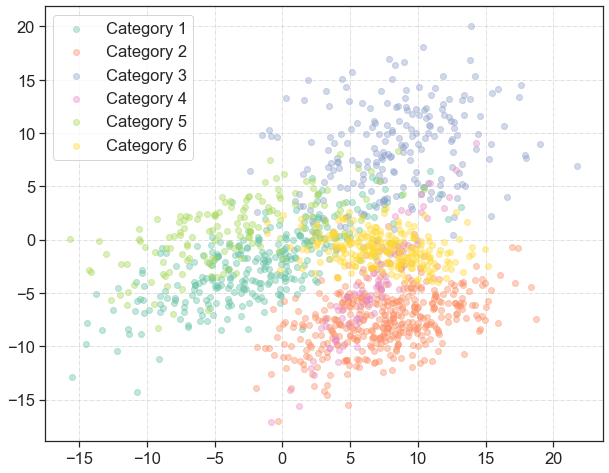

In [167]:
#With n=6
n = 6
N = np.array([300, 400, 200, 100, 150, 250]) 
M,C = n_cat2Dgauss(n,N)

for i in range(n):
    print("Mean of category", i+1, "=", '\n', M[i],'\n')
    print("Covariance matrix of category", i+1, "=", '\n', C[i], '\n')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [168]:
#Download the dataset and load it as a pandas dataframe. Inspect the dataset.
df = pd.DataFrame(np.load('residuals_261.npy', allow_pickle = True).item())
df

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


In [169]:
#Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
cldf = df[abs(df['residuals']) < 2]
cldf.describe()

,residuals,distances
count,10489.000000,10489.000000
mean,-0.121878,9.954824
std,0.439143,5.847142
min,-2.000000,0.000000
25%,-0.280000,4.700000
50%,-0.100000,10.000000
75%,0.070000,15.100000
max,1.992857,24.900000


Linear regression y = mx + q: 
 m: 0.003260    q: -0.154328


Text(0, 0.5, 'Residuals')

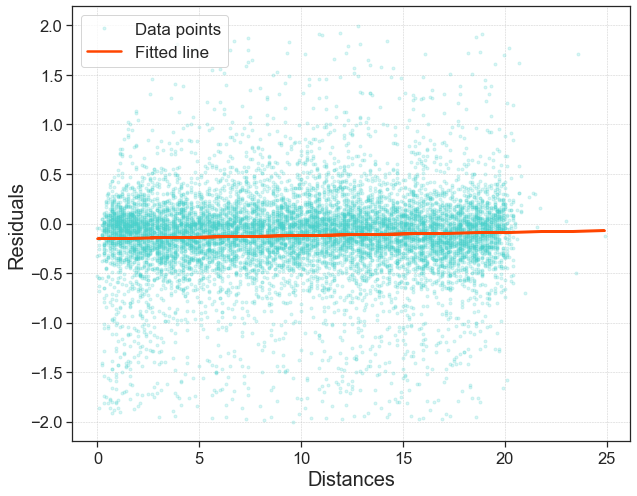

In [170]:
#Perform a linear regression of "residuals" versus "distances" using scipy.stats.linregress()
x = cldf['distances']
y = cldf['residuals']

m, q, r_value, p_value, std_err = stats.linregress(x, y)
print("Linear regression y = mx + q:", '\n', "m: %f    q: %f" % (m, q))

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(x, y, '.', color = 'mediumturquoise',label = 'Data points',alpha=0.2)
ax.plot(x, q + m*x, color = 'orangered',linewidth = 2.5 , label = 'Fitted line')
ax.grid(linestyle = "--", linewidth = 0.5)
ax.legend(loc = "best", fontsize = 17)
ax.set_xlabel('Distances', fontsize = 20)
ax.set_ylabel('Residuals', fontsize = 20)


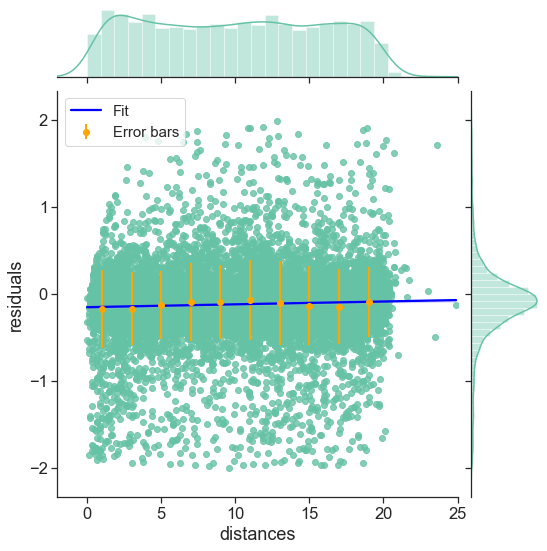

In [171]:
#Seaborn plot
sns.set(style='ticks', palette="Set2", font_scale = 1.5)
sns.jointplot(x="distances", y="residuals", data=cldf, kind="reg",xlim=[-2, 25], height = 8, line_kws={'color':'blue', 'label':'Fit'})

n_bins = 10                              #number of bins
binedgs = np.linspace(0, 20, n_bins+1)   #bin edges
x = (binedgs + 20/(n_bins*2))[:-1]       #bin centers

for i in range(len(x)):
    binclass = (binedgs[i] <= cldf["distances"]) & (cldf["distances"] < binedgs[i+1]) #mask to select data in bin
    cldf.loc[binclass, "bin"] = int(i) #add column "bin" reporting the number of bin the entry belongs to 

y = cldf.groupby("bin")["residuals"].mean().values    #perform mean of residuals in same bin
yerr = cldf.groupby("bin")["residuals"].std().values  #std dev

plt.errorbar(x, y, yerr, label = 'Error bars', linewidth = 2, fmt = 'o', c='orange')
plt.legend(loc = "best", fontsize = 15)